# Documentação do desafio datascience intelivix (avançado)

Para esse desafio foram utilizados os pacotes **NLTK** e **sklearn** para o processamento dos textos e classificação dos dados, respectivamente. Essa documentação está dividida conforme descrito no **README.md**, através das seguintes etapas:

1. Bibliotecas utilizadas
2. Análise dos dados
    2.1. Seleão das classes
    2.2. Construção das bases de treinamento e teste
3. Treinamento
    3.1 Pré-processamento
    3.2 Classificação
4. Teste
5. Conclusões

---

## 1. Bibliotecas utilizadas

As seguintes bibliotecas foram utilizadas para a execução do código desenvolvido:

In [17]:
from __future__ import division

from nltk.corpus import brown
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer

from sklearn.metrics import confusion_matrix
from sklearn.grid_search import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn import svm

import operator
import random
import csv
import numpy
import json
import time
import math
import string
import itertools
import numpy as np

import matplotlib.pyplot as plt



/home/vfp/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/vfp/.local/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## 2. Análise dos dados

### 2.1. Seleção das classes

O primeiro passo é caracterizado pela seleção das categorias a serem avaliadas pelo modelo. O pacote Brown do NLTK possui um arquivo contendo uma lista dos *ids* de todos os documentos e suas respectivas etiquetas em **cats.txt**. A partir da leitura desse arquivo é possível identificar as classes majoritárias a serem selecionadas. O seguinte *script* realiza esse processo:

In [18]:
categories_count = {x: 0 for x in brown.categories()}

_id = u'cats.txt'
file = brown.open(_id)

for line in file:
	category = line.rstrip('\n').split()[1]
	categories_count[category] += 1

sortedlist = sorted(categories_count.items(), key=operator.itemgetter(1), reverse=True)

print "Category 0: "+sortedlist[0][0]
print "Category 1: "+sortedlist[1][0]

Category 0: learned
Category 1: belles_lettres


### 2.2. Construção das bases de treinamento e teste

Uma vez definidas as categorias que serão avaliadas é possível extrair do pacote Brown apenas os textos relevantes e dividí-los em conjuntos de treinamento e teste. 66% dos textos são selecionados aleatoriamente para a base de treinamento e o restante é utilizado como base de teste.

Para examinar a robustez do algoritmo a separação dos dados e o subsequente treinamento são realizados 10 vezes para garantir que o resultado é independente dos textos escolhidos para cada base do modelo.

In [19]:
def getrelevant():
	cat0 = u'learned' 			# cjNN
	cat1 = u'belles_lettres'	# cgNN

	_id = u'cats.txt'
	file = brown.open(_id)

	relevant_files = []
	for line in file:
		category = line.rstrip('\n').split()[1]
		if category == cat0 or category == cat1:
			relevant_files.append(line.split()[0])

	return relevant_files

relevant_files = getrelevant()
trainset = random.sample(relevant_files, 103)
testset = [x for x in relevant_files if x not in trainset]

## 3. Treinamento

Com posse do conjunto de textos de treinamento iniciamos a fase de treinamento. 

### 3.1. Pré-processamento

O pré-processamento dos textos é o processo onde são retirados dos textos pontuações, stopwords e os tokens resultantes são submetidos a um processo de stemmização (os textos da base Brown do NLTK já estão tokenizados, portanto essa etapa do pré-processamento faz-se desnecessária).

In [20]:
def readfile(fileid):
	rawfile = brown.open(fileid)
	return rawfile.read()

def preprocess(file):
	words = file.split()
	_stopwords = stopwords.words('english')
	stemmer = LancasterStemmer()
	expanded_punctuation = ""
	for symbol in string.punctuation:
		expanded_punctuation += symbol+symbol

	# Remove the tags and punctuation from text
	untagged = []
	for word in words:
		coreword = word[:word.index('/')]
		if coreword not in expanded_punctuation:
			untagged.append(coreword)

	# Remove stopwords from text
	filtered = [w for w in untagged if w.lower() not in _stopwords]

	# Stemm text
	for i in range(0,len(filtered)):
		filtered[i] = stemmer.stem(filtered[i])

	return filtered

Nesse ponto definimos ma classe chamada **InvertedIndex** responsável por construir, através do conjunto de treinamento, uma tabela de índice invertido, a fim de facilitar o processo posterior de cálculo da matrix TF-IDF. A inicialização dessa classe trabalha sobre o conjunto de treinamento, realizando o processo de pré-processamento dos textos.

A função **tf_idf** atua sobre a tabela de índice invertido construída durante a inicialização e retorna uma matrix TF-IDF dos textos e as categorias referentes a cada documento. A matrix TF-IDF é uma matriz em que cada linha representa um documento e cada coluna representa o valor TF-IDF referente a um par (documento,token),a fim de que cada coluna atue como um atributo do documento em questão. Essa mesma função pode realzar esses cálculos sobre a base de testes, caso esta seja passada por parâmetro. O cálculo da matriz de teste é mais custoso, pois não é possível elaborar a tabela de índice invertido do conjunto de teste, em vez disso é necessário pré-processar cada documento durante a iteração.

Ainda nessa classe definimos uma função de filtragem, **trim**. Esta função elimina da lista de tokens aqueles que apresentam menor valor para o modelo, ou seja, tokens que não sejam capazes de representar bem uma das duas categorias. Para atingir esse efeito removemos os tokens presentes apenas em um documento e tokens que estão presentes em ambas as categorias na mesma proporção, assim mantemos apenas os tokens que representam apenas uma categoria (não consideramos tokens representativos de um único documento pois o objetivo é classificação e não *page-ranking*). Realizamos essa *limpeza* dos dados, pois devido a ordem de grandeza dos tokens (mais de 110.000 tokens únicos) comparada aos documentos disponíveis para o treinamento (cerca de 100 documentos) torna-se difícil para o classificador estabelecer uma separação entre as duas classes. 

In [21]:
class InvertedIndex():

	def __init__(self, trainset):
		self.table = {}
		self.tokens = []
		self.documents = trainset

		start = time.time()

		for fileid in trainset:
			file = readfile(fileid)
			processed = preprocess(file)

			for token in processed:

				if token not in self.table:
					self.table[token] = dict()
					self.tokens.append(token)

				token_data = self.table[token]
				if fileid not in token_data:
					token_data[fileid] = 1
				else:
					token_data[fileid] += 1

		finish = time.time()
		elapsed = finish - start
		#print "Built inverted index from "+str(len(self.documents))+" documents in "+str(elapsed)+" seconds."

	def __str__(self):
		return json.dumps(self.table, indent=1)

	def __repr__(self):
		return json.dumps(self.table, indent=1)

	def tf_idf(self, idset=[]):
		if len(idset) == 0:
			start = time.time()
			matrix = [[0 for x in range(len(self.tokens))] for y in range(len(self.documents))]
			classes = []

			step = 100.0/len(self.documents)
			for i in range(0, len(self.documents)):
				for j in range(0,len(self.tokens)+1):
					if j == len(self.tokens):
						if self.documents[i][1] == 'j':
							classes.append(0)
						else:
							classes.append(1)
					else:
						tf = self._tf(self.tokens[j], self.documents[i])
						idf = self._idf(self.tokens[j])

						matrix[i][j] = tf*idf

				val = i*step
				#print ""+str(val)+"% complete..."

			finish = time.time()
			elapsed = finish - start
			#print "Built tf-idf matrix in "+str(elapsed)+" seconds."

			return matrix, classes

		else:
			start = time.time()
			matrix = [[0 for x in range(len(self.tokens))] for y in range(len(idset))]

			step = 100.0/len(idset)
			for i in range(0, len(idset)):
				file = readfile(idset[i])
				processed = preprocess(file)

				for j in range(0,len(self.tokens)):
					tf = self._tf(self.tokens[j], processed)
					idf = self._idf(self.tokens[j])

					matrix[i][j] = tf*idf

				val = i*step
				#print ""+str(val)+"% complete..."

			finish = time.time()
			elapsed = finish - start
			#print "Built tf-idf matrix in "+str(elapsed)+" seconds."

			return matrix
		

	def _tf(self, term, document):
		if isinstance(document, list):
			if term in document:
				frequency = 0
				for token in document:
					if token == term:
						frequency += 1
				return 1 + math.log10(frequency)
			else:
				return 0
		else:
			if document in self.table[term]:
				frequency = self.table[term][document]
				return 1 + math.log10(frequency)
			else:
				return 0

	def _idf(self, term):
		N = len(self.tokens)
		document_frequency = len(self.table[term].keys())
		return math.log10(N/1 + document_frequency)

	def trim(self, ratio=0.5):
		for token in self.tokens:
			docs = self.table[token]
			js, gs = 0, 0
			for doc in docs:
				if doc[1] == 'j':
					js += 1
				else:
					gs += 1
			major = gs if gs > js else js
			fraction = major / (gs+js)
			if len(docs) == 1 or fraction <= ratio: 
				del self.table[token]

		self.tokens = self.table.keys()

Podemos fazer o uso da classe definida e de suas funções para realizar o pré-processamento dos dados obtidos na etapa 2.2.

In [22]:
index = InvertedIndex(trainset)
index.trim()
training_samples, training_classes = index.tf_idf()
test_samples = index.tf_idf(testset)

true_classes = []
for fileid in testset:
    _class = 0 if fileid[1] == 'j' else 1
    true_classes.append(_class)

### 3.2 Classificação

Após terminarmos o pré-processamento dos dados, iniciamos a etapa de classificação. Para essa etapa escolhemos 3 classificadores presentes no pacote **sklearn**: Multilayer Perceptron, Árvores de decisão e Support Vector machine. Para cada um dos classificadores os dados da matriz TF-IDF de treinamento são apresentados para conclusão do treinamento. Nesse momento os classificadores são empregados usando deus parâmetros padrão.

## 4. Teste

### 4.1. Teste padrão

Com os classificadores treinados começamos a etapa de teste, utilizando o conjunto de teste para avaliar a média do erro quadrático e a matriz de confusão de cada um. A impressão da matrix de confusão utiliza uma função própria.

> O *log* completo com o resultado das 10 execuções foram omitidos desse segmento a fim de evitar comprometer a organização visual e se encontra em /results/confusion-matrix/default/.

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

MLP::mse: 		0.134615384615
Confusion matrix, without normalization
[[23  4]
 [ 3 22]]


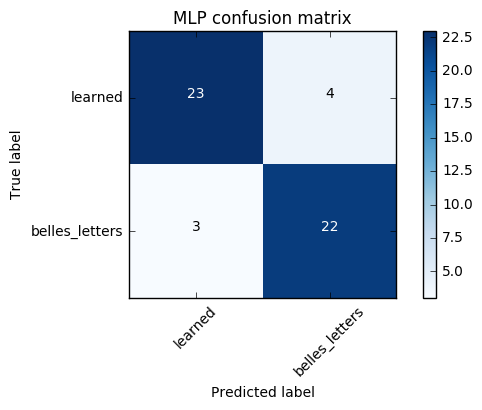

Decision tree::mse: 	0.288461538462
Confusion matrix, without normalization
[[20  7]
 [ 8 17]]


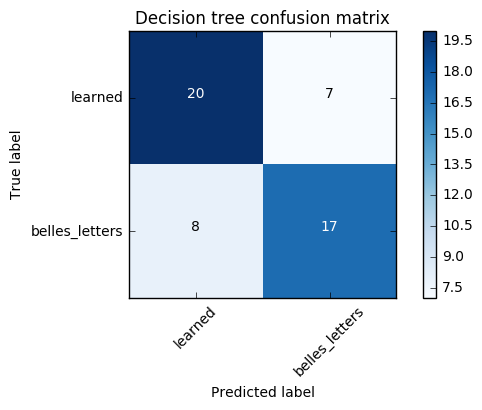

SVM::mse: 		0.153846153846
Confusion matrix, without normalization
[[19  8]
 [ 0 25]]


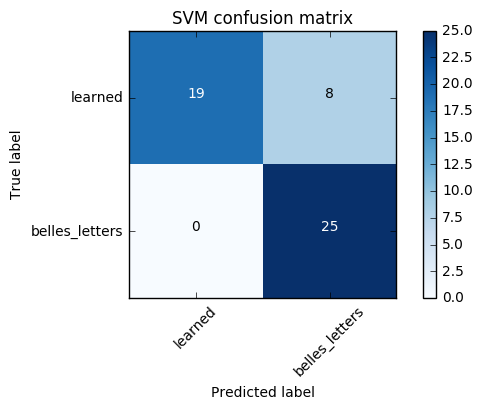

In [24]:
# ==================================================
# MLP classifier
# ==================================================

# Training step
#print "Starting training step..."
classifier = MLPClassifier()
classifier.fit(training_samples, training_classes)
#print "Finished training."

# Testing step
#print "Starting testing step..."
predicted_classes = classifier.predict(test_samples)

misses = 0
for i in range(0, len(testset)):
    if true_classes[i] != predicted_classes[i]:
        misses += 1

mse = misses / len(testset)
print "MLP::mse: \t\t"+str(mse)

# Confusion matrix setup
cnf_matrix = confusion_matrix(true_classes, predicted_classes)
numpy.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['learned','belles_letters'],
    title='MLP confusion matrix')

plt.show()

# ==================================================
# Decision tree classifier
# ==================================================

# Training step
#print "Starting training step..."
classifier = tree.DecisionTreeClassifier()
classifier.fit(training_samples, training_classes)
#print "Finished training."

# Testing step
#print "Starting testing step..."
predicted_classes = classifier.predict(test_samples)

misses = 0
for i in range(0, len(testset)):
    if true_classes[i] != predicted_classes[i]:
        misses += 1

mse = misses / len(testset)
print "Decision tree::mse: \t"+str(mse)

# Confusion matrix setup
cnf_matrix = confusion_matrix(true_classes, predicted_classes)
numpy.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['learned','belles_letters'],
    title='Decision tree confusion matrix')

plt.show()

# ==================================================
# Support vector machine classifier
# ==================================================

# Training step
#print "Starting training step..."
classifier = svm.SVC()
classifier.fit(training_samples, training_classes)
#print "Finished training."

# Testing step
#print "Starting testing step..."
predicted_classes = classifier.predict(test_samples)

misses = 0
for i in range(0, len(testset)):
    if true_classes[i] != predicted_classes[i]:
        misses += 1

mse = misses / len(testset)
print "SVM::mse: \t\t"+str(mse)

# Confusion matrix setup
cnf_matrix = confusion_matrix(true_classes, predicted_classes)
numpy.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['learned','belles_letters'],
    title='SVM confusion matrix')

plt.show()

### 4.2. Ajuste dos hiperparâmetros

Os resultados iniciais dos testes apontam um resultado superior para o classificador SVM, porém, antes de decidirmos qual o melhor classificador devemos realizar os ajustes dos hiperparâmetros para repetir os testes, dessa vez utilizando os melhores parâmetros. A otimização dos parâmetros foi feita utilizando busca em grade exaustiva.

> Mais uma vez os testes completos foram omitidos para melhor organização da documentação e encontram-se em /results/hiper-param-tunning/. Os parâmetros ótimos escolhidos para a seção 4.3 foram baseados nos resultados encontrados nos nos testes mencionados, portanto pode haver algumas inconsistências entre os esses parâmetros e os *scores* encontrados nos ajustes desta seção, pois aqui realizamos apenas uma iteração a fim de exemplificar.

Para o classificador MLP escolhemos os parâmetros: neurônios na camada escondida, ativação, algoritmo solucionador, alfa, taxa de aprendixagem e taxa de aprendizagem inicial.

In [25]:
# ==================================================
# MLP classifier
# ==================================================

# MLP parameters
params = {
'hidden_layer_sizes' : np.array([(50,),(100,),(200)]),
'activation' : np.array(['identity','logistic','tanh','relu']),
'solver' : np.array(['lbfgs','sgd','adam']),
'alpha' : np.array([0.001,0.0001,0.00001]),
'learning_rate' : ['constant','invscaling','adaptive'],
'learning_rate_init' :  np.array([0.01,0.001,0.0001])}

for param in params.keys():
    print "========================================"
    print "Testing values for '"+param+"'"
    print "========================================"
    classifier = MLPClassifier()
    grid = GridSearchCV(estimator=classifier, #verbose=10,
        param_grid={param:params[param]})
    grid.fit(training_samples, training_classes)
    #print(grid)
    print "> Best score: "+str(grid.best_score_)
    print "> Best param: "+str(getattr(grid.best_estimator_,param))

Testing values for 'solver'
> Best score: 0.825242718447
> Best param: sgd
Testing values for 'activation'
> Best score: 0.864077669903
> Best param: logistic
Testing values for 'hidden_layer_sizes'
> Best score: 0.834951456311
> Best param: (50,)
Testing values for 'alpha'
> Best score: 0.796116504854
> Best param: 1e-05
Testing values for 'learning_rate'
> Best score: 0.796116504854
> Best param: invscaling
Testing values for 'learning_rate_init'
> Best score: 0.844660194175
> Best param: 0.01


Para o classificador Árvore de Decisão escolhemos os parâmetros: critério de divisão, características máximas consideradas, número mínimo de amostras na divisão e número mínimo de amostras nas folhas.

In [26]:
# ==================================================
# Decision tree classifier
# ==================================================

# Decision tree parameters
params = {
'criterion' : ['gini','entropy'],
'max_features' : ['auto', 'sqrt', 'log2', None],
'min_samples_split' : np.array([2,4,6]),
'min_samples_leaf' : np.array([1,2,3])
}

for param in params.keys():
    print "========================================"
    print "Testing values for '"+param+"'"
    print "========================================"
    classifier = tree.DecisionTreeClassifier()
    grid = GridSearchCV(estimator=classifier, #verbose=10,
        param_grid={param:params[param]})
    grid.fit(training_samples, training_classes)
    #print(grid)
    print "> Best score: "+str(grid.best_score_)
    print "> Best param: "+str(getattr(grid.best_estimator_,param))

Testing values for 'max_features'
> Best score: 0.68932038835
> Best param: None
Testing values for 'min_samples_split'
> Best score: 0.73786407767
> Best param: 2
Testing values for 'criterion'
> Best score: 0.73786407767
> Best param: entropy
Testing values for 'min_samples_leaf'
> Best score: 0.796116504854
> Best param: 2


Para o classificador SVM escolhemos os parâmetros: Taxa C, valor de kernel e gama.

In [27]:
# ==================================================
# Support vector machine classifier
# ==================================================

# SVM parameters
params = {
'C' : np.array([1.0,10.0,100.0]),
'kernel' : ["linear","poly","rbf","sigmoid"],
'gamma' : np.array([1e-3,1e-4,1e-5])}

for param in params.keys():
    print "========================================"
    print "Testing values for '"+param+"'"
    print "========================================"
    classifier = svm.SVC()
    grid = GridSearchCV(estimator=classifier, #verbose=10,
        param_grid={param:params[param]})
    grid.fit(training_samples, training_classes)
    #print(grid)
    print "> Best score: "+str(grid.best_score_)
    print "> Best param: "+str(getattr(grid.best_estimator_,param))

Testing values for 'kernel'
> Best score: 0.825242718447
> Best param: linear
Testing values for 'C'
> Best score: 0.815533980583
> Best param: 10.0
Testing values for 'gamma'
> Best score: 0.805825242718
> Best param: 0.0001


### 4.3. Teste ajustado

Nesse ponto já possuimos os melhores parâmetros para os classificadores escolhidos, portanto podemos refazer os testes anteriores a fim de comparar o desempenho dos classificadores em consições ideais.

> Os resultados completos dos testes finais encontram-se em /results/confusion-matrix/tunned/.

MLP::mse: 		0.0961538461538
Confusion matrix, without normalization
[[23  4]
 [ 1 24]]


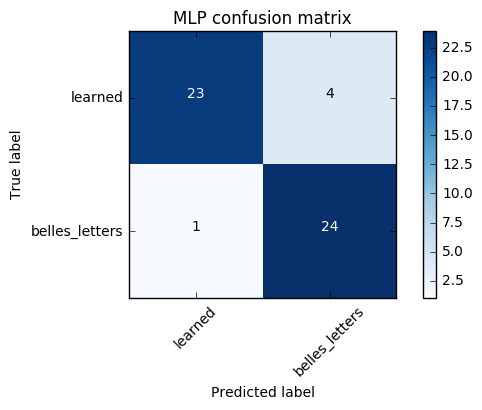

Decision tree::mse: 	0.365384615385
Confusion matrix, without normalization
[[15 12]
 [ 7 18]]


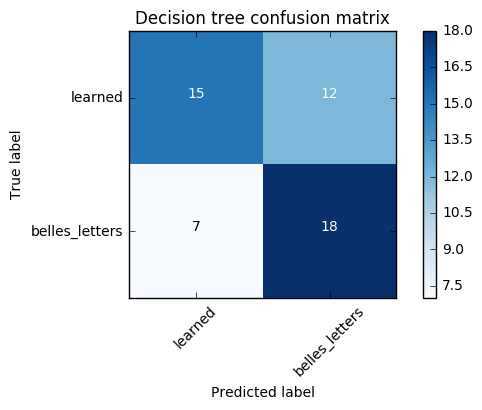

SVM::mse: 		0.153846153846
Confusion matrix, without normalization
[[20  7]
 [ 1 24]]


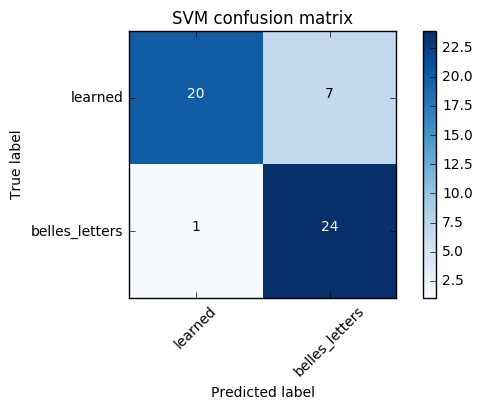

In [29]:
# ==================================================
# MLP classifier
# ==================================================

# Training step
#print "Starting training step..."
classifier = MLPClassifier(solver='lbfgs', activation='logistic',
    hidden_layer_sizes=(50,),alpha=0.001,learning_rate='adaptive',
    learning_rate_init=0.0001)
classifier.fit(training_samples, training_classes)
#print "Finished training."

# Testing step
#print "Starting testing step..."
predicted_classes = classifier.predict(test_samples)

misses = 0
for i in range(0, len(testset)):
    if true_classes[i] != predicted_classes[i]:
        misses += 1

mse = misses / len(testset)
print "MLP::mse: \t\t"+str(mse)

# Confusion matrix setup
cnf_matrix = confusion_matrix(true_classes, predicted_classes)
numpy.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['learned','belles_letters'],
    title='MLP confusion matrix')

plt.show()

# ==================================================
# Decision tree classifier
# ==================================================

# Training step
#print "Starting training step..."
classifier = tree.DecisionTreeClassifier(max_features='sqrt',
    min_samples_split=2, criterion='gini', min_samples_leaf=1)
classifier.fit(training_samples, training_classes)
#print "Finished training."

# Testing step
#print "Starting testing step..."
predicted_classes = classifier.predict(test_samples)

misses = 0
for i in range(0, len(testset)):
    if true_classes[i] != predicted_classes[i]:
        misses += 1

mse = misses / len(testset)
print "Decision tree::mse: \t"+str(mse)

# Confusion matrix setup
cnf_matrix = confusion_matrix(true_classes, predicted_classes)
numpy.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['learned','belles_letters'],
    title='Decision tree confusion matrix')

plt.show()

# ==================================================
# Support vector machine classifier
# ==================================================

# Training step
#print "Starting training step..."
classifier = svm.SVC(kernel='linear', C=1.0, gamma=0.0001)
classifier.fit(training_samples, training_classes)
#print "Finished training."

# Testing step
#print "Starting testing step..."
predicted_classes = classifier.predict(test_samples)

misses = 0
for i in range(0, len(testset)):
    if true_classes[i] != predicted_classes[i]:
        misses += 1

mse = misses / len(testset)
print "SVM::mse: \t\t"+str(mse)

# Confusion matrix setup
cnf_matrix = confusion_matrix(true_classes, predicted_classes)
numpy.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['learned','belles_letters'],
    title='SVM confusion matrix')

plt.show()

## 5. Conclusões

Através dos testes realizados com os parâmetros dos classificadores ajustados, observamos consequências diferentes para cada classificador. O MLP experimentou forte melhoria de desempenho, quanto que Árvore de decisão sofreu pequena queda de desempenho e o SVM quase não foi alterado. Com base nos resultados podemos concluir que o classificador MLP tornou-se, após os ajustes, o melhor classificador dentre os três. 

A hipótese mais forte para os efeitos observados é que o MLP possui uma quantidade maior de parâmetros disponíveis para ajuste, portanto está mais propenso a melhorias durante este processo. Além disso, Redes Neurais são 